In [1]:
# The goal of this file is to predict temperature for all 9 stations for all 24 hours for 7 days

# We also want to include the n
# on-time dependent variables, i.e., include variables that indicate the station number (locations)

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

In [36]:
# Reading in data
temps = pd.read_excel(r"C:\Users\Matthew\PycharmProjects\ISDS-7075-Project\final_project\datasets\dataset.xlsx",
                      sheet_name="temperature_history")

In [37]:
# Creating dummy variables for each of the 9 weather stations
temps = pd.get_dummies(temps, columns=["station_id"])

# Creating a date field
temps["date"] = pd.to_datetime(temps[["year", "month", "day"]], format='%Y-%m-%d', errors='coerce')
train_dates = temps["date"]

print(train_dates)

0       2015-01-01
1       2015-01-01
2       2015-01-01
3       2015-01-01
4       2015-01-01
           ...    
14773   2019-06-29
14774   2019-06-29
14775   2019-06-29
14776   2019-06-29
14777   2019-06-29
Name: date, Length: 14778, dtype: datetime64[ns]


In [38]:
# Identifying which cols for training (h1 is the y in this example)
cols = list(temps)[4:-1]


# New df with only x vars
df_for_training = temps[cols].astype(float)
df_for_training = df_for_training.iloc[0:14715,:]

In [39]:
# LTSM uses sigmoid and tanh that are sensitive to magnitude, so values need to be normalized
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [52]:
trainX = []
trainY = []




n_future = 7
n_past = 14



for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)



In [44]:
# define Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 14, 64)            25088     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 37,537
Trainable params: 37,537
Non-trainable params: 0
_________________________________________________________________


In [45]:
# fit model
history = model.fit(x=trainX, y=trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10
827/827 [==============================] - 6s 6ms/step - loss: 0.0932 - val_loss: 0.0495
Epoch 2/10
827/827 [==============================] - 5s 6ms/step - loss: 0.0621 - val_loss: 0.0426
Epoch 3/10
827/827 [==============================] - 5s 6ms/step - loss: 0.0544 - val_loss: 0.0367
Epoch 4/10
827/827 [==============================] - 5s 6ms/step - loss: 0.0492 - val_loss: 0.0263
Epoch 5/10
827/827 [==============================] - 5s 6ms/step - loss: 0.0434 - val_loss: 0.0314
Epoch 6/10
827/827 [==============================] - 5s 6ms/step - loss: 0.0390 - val_loss: 0.0242
Epoch 7/10
827/827 [==============================] - 5s 6ms/step - loss: 0.0364 - val_loss: 0.0186
Epoch 8/10
827/827 [==============================] - 5s 6ms/step - loss: 0.0351 - val_loss: 0.0168
Epoch 9/10
827/827 [==============================] - 5s 6ms/step - loss: 0.0332 - val_loss: 0.0181
Epoch 10/10
827/827 [==============================] - 5s 6ms/step - loss: 0.0339 - val_loss: 0.0226

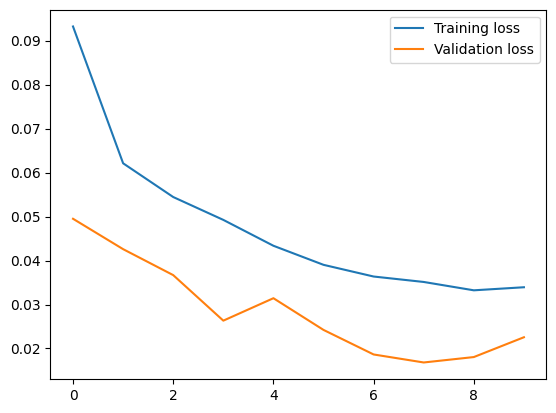

In [47]:
# plotting training/validation loss

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [49]:
# Forecasting
# start with the last day in training set and predict future
n_future = 63
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()

forecast = model.predict(trainX[-n_future:])

2/2 [==============================] - 0s 3ms/step


In [50]:
# Perform inverse transformation to rescale back to original range

forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
h1_future = scaler.inverse_transform(forecast_copies)[:,0]
print(h1_future)

[70.640236 77.72397  70.726425 74.09572  79.50617  77.18088  77.72986
 76.14853  77.910385 69.657776 77.49251  70.70686  70.230576 77.71091
 71.08471  77.54887  74.1533   75.531    64.651535 76.07743  64.282486
 69.70007  72.76233  71.02255  70.007    70.31088  70.43484  65.4301
 77.078865 65.49022  68.2688   72.01457  69.310104 71.279686 72.13067
 73.30465  64.95293  74.02177  65.80912  70.31005  75.99792  71.12596
 72.748    70.84444  73.35012  69.69519  78.952835 70.26808  74.29751
 78.65837  75.27379  77.00971  76.8506   77.96396  72.27946  79.84995
 72.572    75.809    79.03652  76.98732  77.18369  76.40009  76.665565]


In [16]:
# Convert timestamp to date

forecast_dates =[]

for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [21]:
# Date and h1 prediction columns

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'h1':y_pred_future})
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

print(df_forecast)

         Date         h1
0  2019-06-29  78.807388
1  2019-06-30  76.582916
2  2019-07-01  76.297523
3  2019-07-02  77.801979
4  2019-07-03  76.510162
5  2019-07-04  72.094345
6  2019-07-05  78.575760
7  2019-07-06  71.975677
8  2019-07-07  76.199913
9  2019-07-08  78.076698
10 2019-07-09  77.259346
11 2019-07-10  76.290825
12 2019-07-11  77.691422
13 2019-07-12  75.547386
